En este código se encuentra el paso a paso de nuestro proyecto final del máster, en el que se extraen datos de distintas API's para lograr compilar datos y lograr armar un modelo para predecir la probabilidad de que USA entre en recesión económica

In [43]:
!python -m pip install joblib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import requests
import pandas as pd
from fred_key import fred_key
import openpyxl
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

El siguiente código sirve para descargar el SP&500 utilizando la API yfinance

In [53]:
today_date = datetime.today().strftime('%Y-%m-%d')


spy_ohlc_df = yf.download('SPY', start='1977-06-01', end=today_date, interval='1mo')


#Reset Index
spy_ohlc_df.reset_index(inplace=True)

# Crear el dataframe con las columnas de fecha y cierre del índice
new_spy = pd.DataFrame({
    'Date': spy_ohlc_df['Date'],  
    'Close': spy_ohlc_df['Close']  
})

new_spy

[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,1993-02-01,44.406250
1,1993-03-01,45.187500
2,1993-04-01,44.031250
3,1993-05-01,45.218750
4,1993-06-01,45.062500
...,...,...
368,2023-10-01,418.200012
369,2023-11-01,456.399994
370,2023-12-01,475.309998
371,2024-01-01,482.880005


Para descargar los datos desde la API de la FRED:

In [54]:
api_key = fred_key

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

# Define indicators and their corresponding FRED series IDs
indicators = {
   'VIX': 'VIXCLS', #Daily #1976-06-01
   'Unemployment': 'UNRATE', #Montlhy #1948-01-01
   #'S&P500': 'SP500', #Daily #1920
   'CPI': 'CPIAUCNS', #Montlhy #1913-01-01
   'Interest_Rates': 'FEDFUNDS', #Montlhy #1954-07-01
   'YIC':'T10Y2Y', #Daily #1976-06-01 
   'USREC_1' : 'USREC' #Monthly #1854-12-01
}

# Assign common parameters
start_date = '1993-02-01'
end_date = today_date
file_type = 'json'
ts_frequency = 'm'
#ts_units = 'pc1' #percentaje value from last year

# Fetch data for each indicator
data_frames = {}
for indicator, series_id in indicators.items():
    obs_params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': file_type,
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': ts_frequency,
        #'units': ts_units #percentaje value from last year
    }

    # Make request to FRED API
    response = requests.get(base_url + 'series/observations', params=obs_params)

    # Create DataFrame for each indicator
    if response.status_code == 200:
        res_data = response.json()
        obs_data = pd.DataFrame(res_data['observations'])
        obs_data['date'] = pd.to_datetime(obs_data['date'])
        obs_data.set_index('date', inplace=True)
        obs_data['value'] = obs_data['value']
        data_frames[indicator] = obs_data
    else:
        print(f'Failed to retrieve data for {indicator}. Status code:', response.status_code)


In [55]:
# Display the modified DataFrames for each indicator
for indicator, df in data_frames.items():
    # Create a modified DataFrame by dropping specified columns
    modified_df = df.drop(['realtime_start', 'realtime_end'], axis=1)
    
    # Store the modified DataFrame in the dictionary
    data_frames[indicator] = modified_df


# Combine all modified DataFrames based on the 'date' column
combined_df = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())


# Reset Index
combined_df.reset_index(inplace=True)



combined_df

,date,VIX,Unemployment,CPI,Interest_Rates,YIC,USREC_1
,,value,value,value,value,value,value
0,1993-02-01,13.72,7.1,143.1,3.03,2.16,0
1,1993-03-01,13.61,7.0,143.6,3.07,2.03,0
2,1993-04-01,12.84,7.1,144.0,2.96,2.13,0
3,1993-05-01,13.61,7.1,144.2,3.00,2.06,0
4,1993-06-01,12.52,7.0,144.4,3.04,1.80,0
...,...,...,...,...,...,...,...
368,2023-10-01,18.89,3.8,307.671,5.33,-0.27,0
369,2023-11-01,14.02,3.7,307.051,5.33,-0.38,0
370,2023-12-01,12.72,3.7,306.746,5.33,-0.44,0


In [56]:

# Seleccionar las columnas que deseas convertir a float64
columnas = combined_df.columns[1:]

# Iterar sobre cada columna seleccionada y convertir los valores numéricos a tipo float64
for col in columnas:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df


,date,VIX,Unemployment,CPI,Interest_Rates,YIC,USREC_1
,,value,value,value,value,value,value
0,1993-02-01,13.72,7.1,143.100,3.03,2.16,0.0
1,1993-03-01,13.61,7.0,143.600,3.07,2.03,0.0
2,1993-04-01,12.84,7.1,144.000,2.96,2.13,0.0
3,1993-05-01,13.61,7.1,144.200,3.00,2.06,0.0
4,1993-06-01,12.52,7.0,144.400,3.04,1.80,0.0
...,...,...,...,...,...,...,...
368,2023-10-01,18.89,3.8,307.671,5.33,-0.27,0.0
369,2023-11-01,14.02,3.7,307.051,5.33,-0.38,0.0
370,2023-12-01,12.72,3.7,306.746,5.33,-0.44,0.0


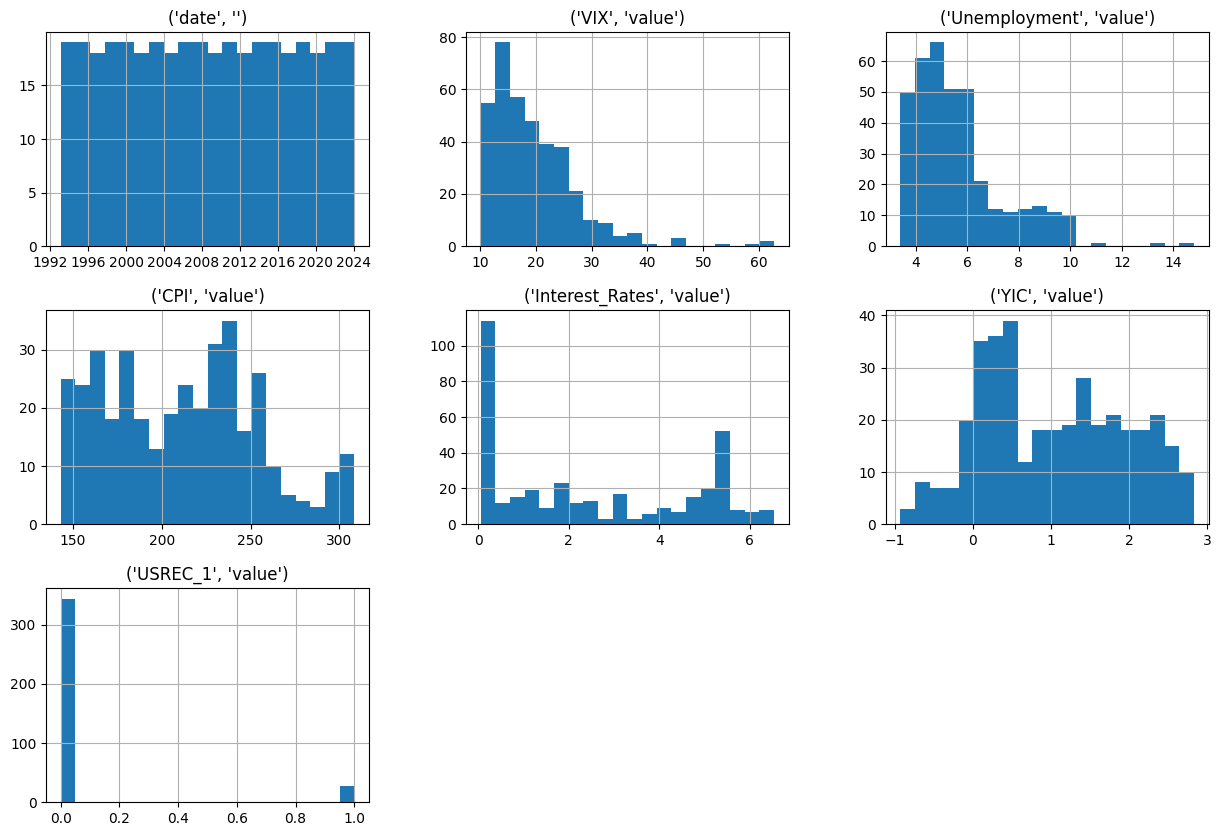

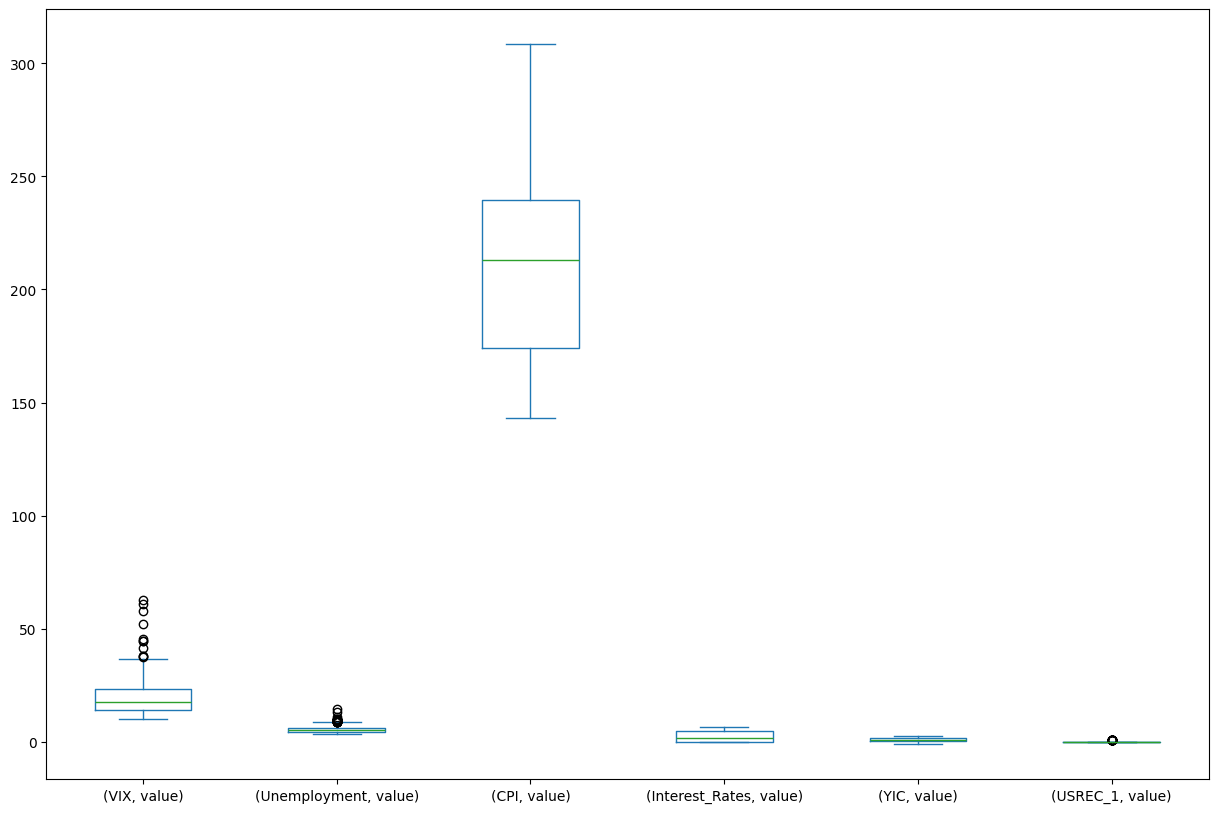

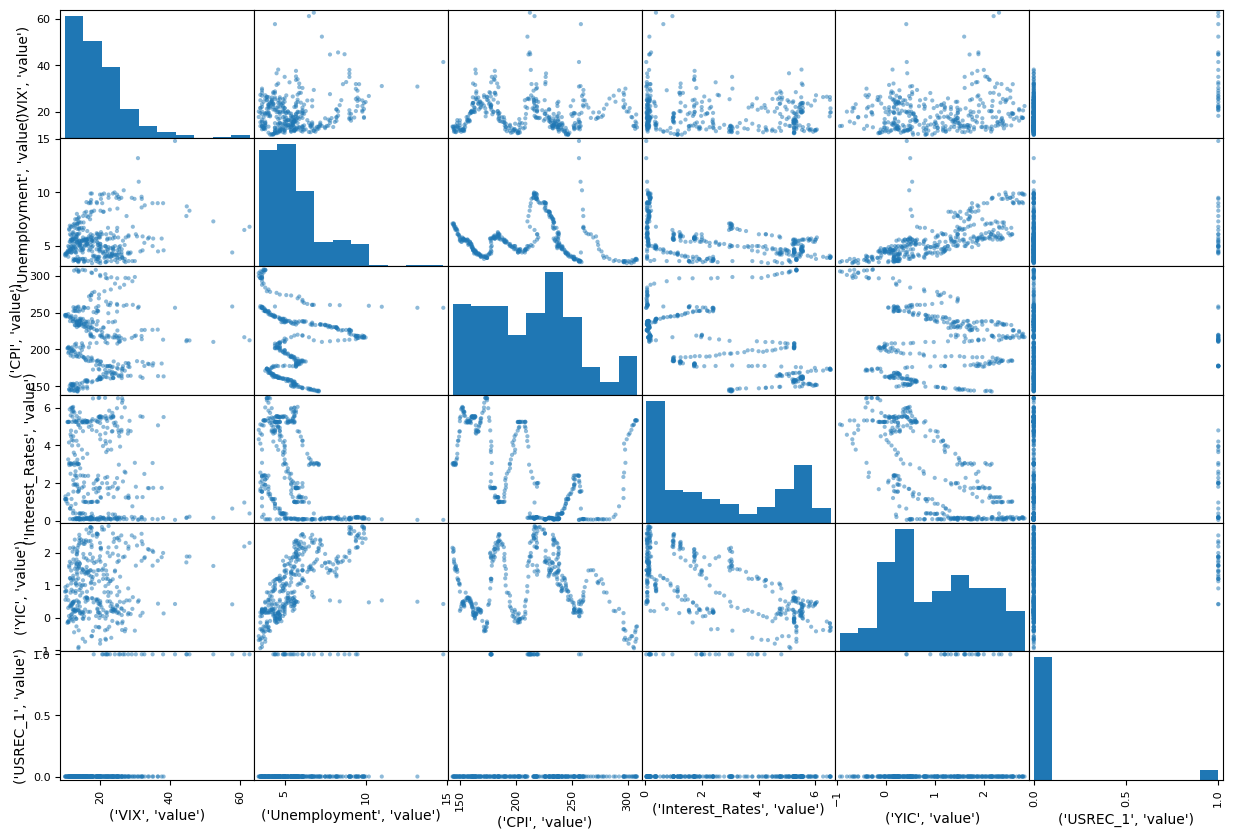

In [57]:
# Calcula las estadísticas descriptivas para cada indicador
descriptive_stats = combined_df.describe()

# Crea un histograma para cada indicador
combined_df.hist(bins=20, figsize=(15,10))
plt.show()

# Crea gráficos de caja para cada indicador
combined_df.plot(kind='box', figsize=(15,10))
plt.show()

# Crea diagramas de dispersión para las columnas del dataframe, a partir de la segunda columna
columnas = combined_df.columns[1:]

# Crear diagramas de dispersión para las variables seleccionadas
pd.plotting.scatter_matrix(combined_df[columnas], figsize=(15, 10))
plt.show()

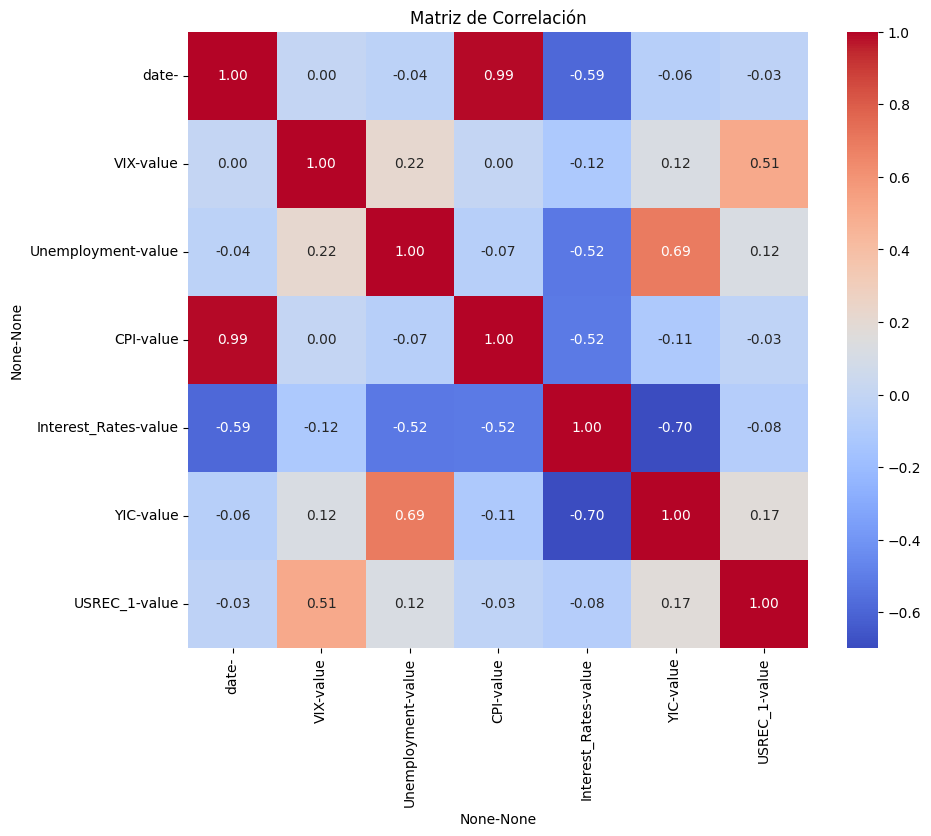

In [58]:
# Matriz de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [59]:

# Convertir la columna de fechas a una representación numérica antes de la división de datos
combined_df['date'] = combined_df['date'].astype('int64')

# Suponiendo que df contiene tu DataFrame original con los datos
X = combined_df.drop('USREC_1', axis=1)
y = combined_df['USREC_1']

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el objeto scaler en un archivo
joblib.dump(scaler, 'scaler.pkl')

# Cargar el objeto scaler desde el archivo
scaler_loaded = joblib.load('scaler.pkl')

combined_df


# # Guarda el objeto scaler para usarlo más tarde en los datos de prueba
# scaler_filename = "scaler.pkl"
# joblib.dump(scaler, scaler_filename)

C:\Users\ejvia\AppData\Local\Temp\ipykernel_15148\4175193288.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = combined_df.drop('USREC_1', axis=1)


,date,VIX,Unemployment,CPI,Interest_Rates,YIC,USREC_1
,,value,value,value,value,value,value
0,728524800000000000,13.72,7.1,143.100,3.03,2.16,0.0
1,730944000000000000,13.61,7.0,143.600,3.07,2.03,0.0
2,733622400000000000,12.84,7.1,144.000,2.96,2.13,0.0
3,736214400000000000,13.61,7.1,144.200,3.00,2.06,0.0
4,738892800000000000,12.52,7.0,144.400,3.04,1.80,0.0
...,...,...,...,...,...,...,...
368,1696118400000000000,18.89,3.8,307.671,5.33,-0.27,0.0
369,1698796800000000000,14.02,3.7,307.051,5.33,-0.38,0.0
370,1701388800000000000,12.72,3.7,306.746,5.33,-0.44,0.0


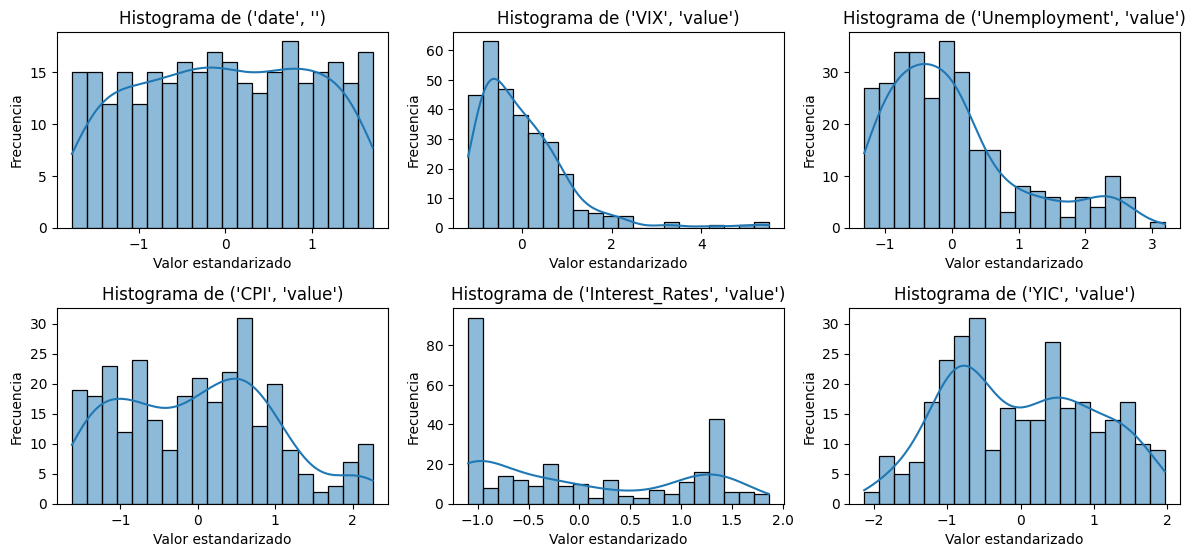

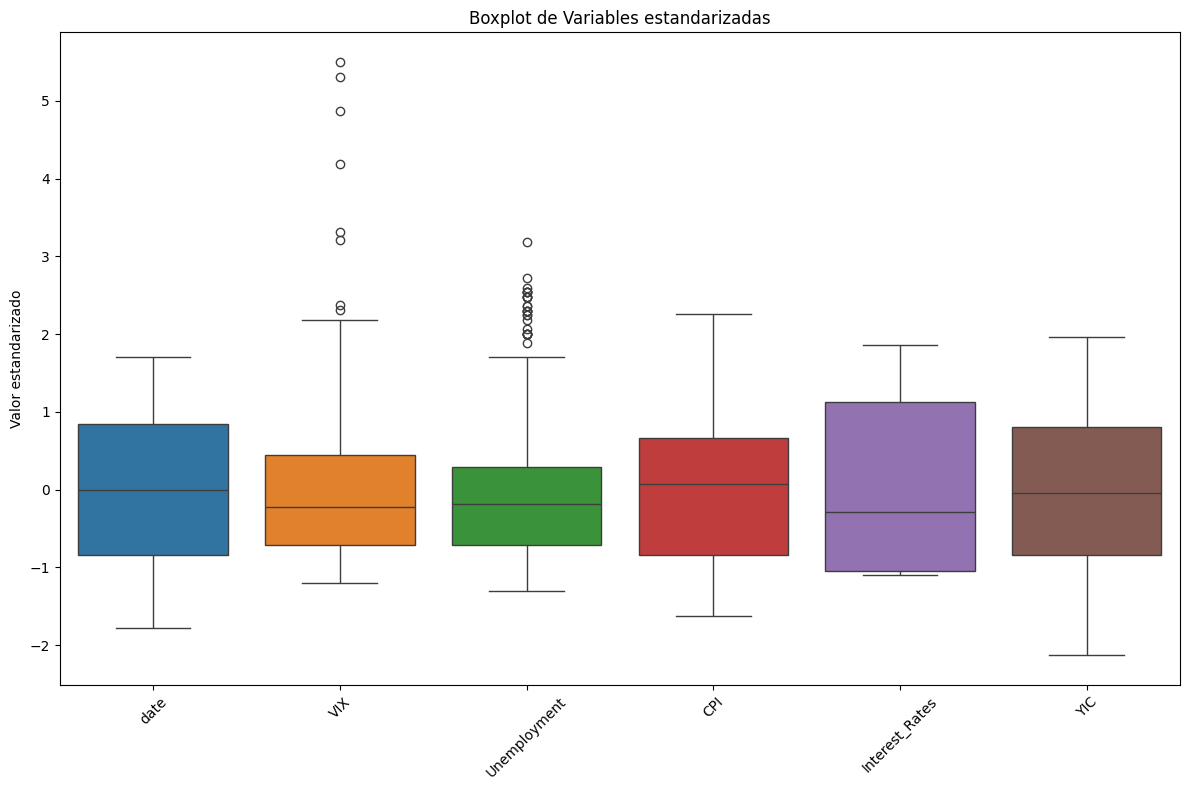

ValueError: Data must be 1-dimensional, got ndarray of shape (298, 1) instead

<Figure size 800x600 with 0 Axes>

In [61]:
# Histogramas de las variables estandarizadas
plt.figure(figsize=(12, 8))
for i, column in enumerate(X_train.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_train_scaled[:, i], bins=20, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valor estandarizado')
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots de las variables estandarizadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame(X_train_scaled, columns=X_train.columns))
plt.title('Boxplot de Variables estandarizadas')
plt.ylabel('Valor estandarizado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Diagrama de dispersión de las dos primeras variables estandarizadas
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_scaled[:, 0].ravel(), y=X_train_scaled[:, 1].ravel(), hue=y_train, palette='Set1')
plt.title('Diagrama de Dispersión de las dos primeras variables estandarizadas')
plt.xlabel('Variable estandarizada 1')
plt.ylabel('Variable estandarizada 2')
plt.legend(title='Recesión', loc='upper right')
plt.tight_layout()
plt.show()
